# Notebook to examine the ratio of the counts in the 2614 and 583 keV peaks

The skimmed files exist as .parquet files in the path `/data1/users/krause/share/high_lvl/v02_00`. I have temporarily copied these files to a local folder on NERSC for my use, while Sam W figures out the details regarding transferring data to NERSC. Note that as of Jan 10, 2024, it was mentioned that the high level data processing would have to be redone, so it is unclear as to whether this analysis will have to be redone once the final skimmed files are re-generated. (The exact nature of the issue for which the production will have to be repeated is also not clear to me. I think it was related to certain cuts). This code can serve as a starting point for the analysis.

### Miscellaneous functions

In [1]:
def count_integrator(arr, bins, emin, emax):
    hist, edges = np.histogram(arr, bins)
    return sum(hist[emin:emax])

In [2]:
def hatching(col):
    # Add a vertical span with hatching
    ax[0,col].axvspan(xmin=581, xmax=585, color='gray', alpha=0.3, hatch='/')
    ax[0,col].axvspan(xmin=579, xmax=581, color='orange', alpha=0.3, hatch='x')
    ax[0,col].axvspan(xmin=585, xmax=587, color='orange', alpha=0.3, hatch='x')
    # Add text to the region
    ax[0,col].text(583, 250, '583', horizontalalignment='center', verticalalignment='center', fontsize=16, color='black')
    ax[0,col].text(580, 250, 'CC', horizontalalignment='center', verticalalignment='center', fontsize=16, color='red')
    ax[0,col].text(586, 250, 'CC', horizontalalignment='center', verticalalignment='center', fontsize=16, color='red')

    # Add a vertical span with hatching
    ax[1,col].axvspan(xmin=2610, xmax=2620, color='gray', alpha=0.3, hatch='/')
    ax[1,col].axvspan(xmin=2605, xmax=2610, color='orange', alpha=0.3, hatch='x')
    ax[1,col].axvspan(xmin=2620, xmax=2625, color='orange', alpha=0.3, hatch='x')
    # Add text to the region
    ax[1,col].text(2615, 80, '2614', horizontalalignment='center', verticalalignment='center', fontsize=16, color='black')
    ax[1,col].text(2607, 80, 'CC', horizontalalignment='center', verticalalignment='center', fontsize=16, color='red')
    ax[1,col].text(2623, 80, 'CC', horizontalalignment='center', verticalalignment='center', fontsize=16, color='red')

### Reading the data

We will use skimmed files so that it is easy to apply the quality cuts.

In [3]:
import pandas as pd # pandas
import numpy as np # numpy
import os # for listing files in the directory
import glob # Unix style pathname pattern expansion
from datetime   import datetime, timezone #for datetime functions
import matplotlib as mpl
import matplotlib.pyplot as plt # for plotting
import matplotlib.dates as mdates # for dates
import seaborn as sns # for the 2D histogram
from legendmeta import LegendMetadata
from scipy.optimize import curve_fit

lmeta = LegendMetadata()

In [4]:
# Concatenation of files
def read_and_concat_data(group):
    dfs = [pd.read_parquet(file) for file in group]
    return pd.concat(dfs, verify_integrity=True)

In [5]:
# Define the path to the skimmed files
path_to_skimmed_files='/pscratch/sd/j/jita/Ratio_2614_583/skimmed_files/*.parquet'
skimmed_files=sorted(glob.glob(path_to_skimmed_files))
print("The files processed are:")
for file in skimmed_files:
    print(file)
print("__________________________________________________________________________")
data= read_and_concat_data(skimmed_files)
print(f"The keys in the data are:\n{data.keys()}")
print("__________________________________________________________________________")
data

The files processed are:
/pscratch/sd/j/jita/Ratio_2614_583/skimmed_files/p03_r000_to_r005.parquet
/pscratch/sd/j/jita/Ratio_2614_583/skimmed_files/p04_r000_to_r003.parquet
/pscratch/sd/j/jita/Ratio_2614_583/skimmed_files/p06_r000_to_r006.parquet
/pscratch/sd/j/jita/Ratio_2614_583/skimmed_files/p07_r001_to_r007.parquet
__________________________________________________________________________
The keys in the data are:
Index(['aoe', 'aoe_aux', 'dt', 'dt_aux', 'energy', 'energy_aux',
       'energy_aux_id', 'energy_id', 'is_aoe_tagged', 'is_aoe_tagged_aux',
       'is_baseline', 'is_lar_rejected', 'is_lar_rejected_dplms',
       'is_muon_tagged', 'is_physical', 'is_physical_aux', 'is_pulser',
       'is_ringing', 'is_ringing_aux', 'is_saturated', 'is_saturated_aux',
       'is_usable_aoe', 'is_usable_aoe_aux', 'is_valid_channel',
       'is_valid_channel_aux', 'lar_classifier', 'lar_energy',
       'lar_energy_dplms', 'lar_multiplicity', 'lar_multiplicity_dplms',
       'lar_time_shift',

,aoe,aoe_aux,dt,dt_aux,energy,energy_aux,energy_aux_id,energy_id,is_aoe_tagged,is_aoe_tagged_aux,...,lar_energy_dplms,lar_multiplicity,lar_multiplicity_dplms,lar_time_shift,multiplicity,on_multiplicity,rt,rt_aux,t0,t0_aux
timestamp,,,,,,,,,,,,,,,,,,,,,
1.678596e+09,NaN,NaN,-54.273602,-54.273602,185.879236,185.879236,1107203,1107203,False,False,...,1.149703,0.0,1.0,-48448.0,1,1,304.0,304.0,48448.0,48448.0
1.678596e+09,0.420062,0.420062,687.018799,687.018799,769.050247,769.050247,1121605,1121605,False,False,...,0.000000,0.0,0.0,-47632.0,1,1,512.0,512.0,47632.0,47632.0
1.678596e+09,-0.515876,-0.515876,617.147522,617.147522,111.203145,111.203145,1118405,1118405,False,False,...,17.239860,7.0,7.0,-47648.0,1,1,464.0,464.0,47648.0,47648.0
1.678596e+09,NaN,NaN,447.967255,447.967255,240.145878,240.145878,1089601,1089601,False,False,...,8.920335,3.0,3.0,-47824.0,1,1,480.0,480.0,47824.0,47824.0
1.678596e+09,NaN,NaN,NaN,NaN,NaN,NaN,0,0,False,False,...,0.773492,1.0,1.0,0.0,0,0,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.695626e+09,NaN,5.742014,583.979492,191.880249,3322.041284,1119.159006,1086400,1107204,False,True,...,11.990734,14.0,9.0,-48800.0,87,82,352.0,352.0,48800.0,49248.0
1.695626e+09,NaN,NaN,NaN,NaN,NaN,NaN,0,0,False,False,...,0.000000,0.0,0.0,0.0,0,0,NaN,NaN,0.0,0.0
1.695626e+09,-1.836839,-1.836839,1208.402710,1208.402710,103.271304,103.271304,1121600,1121600,False,False,...,0.000000,0.0,0.0,-44608.0,1,1,10144.0,10144.0,44608.0,44608.0


### Defining the channel map

Defining the date time based on a time stamp towards the start of the stable data taking. Since the hardware mapping has not changed, it should be fine.

In [6]:
# Channel map
dt    = datetime(2023, 4, 22, 5, 54, 22, tzinfo=timezone.utc)
chmap = lmeta.hardware.configuration.channelmaps.on(dt)

In [7]:
# Detectors dictionary
detlist=[]
for det, val in chmap.items():
    if val.system == "geds":
        detlist.append(det)
        
channel_dict = {}

for channel_name, channel_data in chmap.items():
    try:
        channel_dict[channel_data['daq']['rawid']] = (lmeta.channelmap(dt)[channel_name].type, channel_name, lmeta.channelmap(dt)[channel_name].production['mass_in_g'], lmeta.channelmap(dt)[channel_name].location.string, lmeta.channelmap(dt)[channel_name].location.position)
    except:
        #print(channel_name)
        continue

In [8]:
# channel and aux channel definition
channel_df = pd.DataFrame.from_dict(channel_dict, orient='index', columns=['det_type', 'channel_name', 'mass', 'string', 'position'])
channel_df_aux = pd.DataFrame.from_dict(channel_dict, orient='index', columns=['det_type_aux', 'channel_name_aux', 'mass_aux', 'string_aux', 'location_aux'])

### Merging the channel map and the data

In [9]:
# data is the master dataframe
data  = pd.merge(data, channel_df, left_on='energy_id', right_index=True, how='left')
data  = pd.merge(data, channel_df_aux, left_on='energy_aux_id', right_index=True, how='left')

### Data selection

Applying the general quality cuts. `is_valid_channel` is False if anticoincidence only detector fired. So for the singles spectrum, this condition takes care of removing the ac detectors.

In [10]:
# Data selection
data_QC = data[(data.is_pulser == False) \
               & (data.is_baseline == False) \
               & (data.is_muon_tagged == False) \
               & (data.is_valid_channel == True) \
               & (data.is_physical == True) \
               & (data.multiplicity == 1)]

Note that the string 6 and string 12 are empty. However, they have been left in the label for convenience of the code.

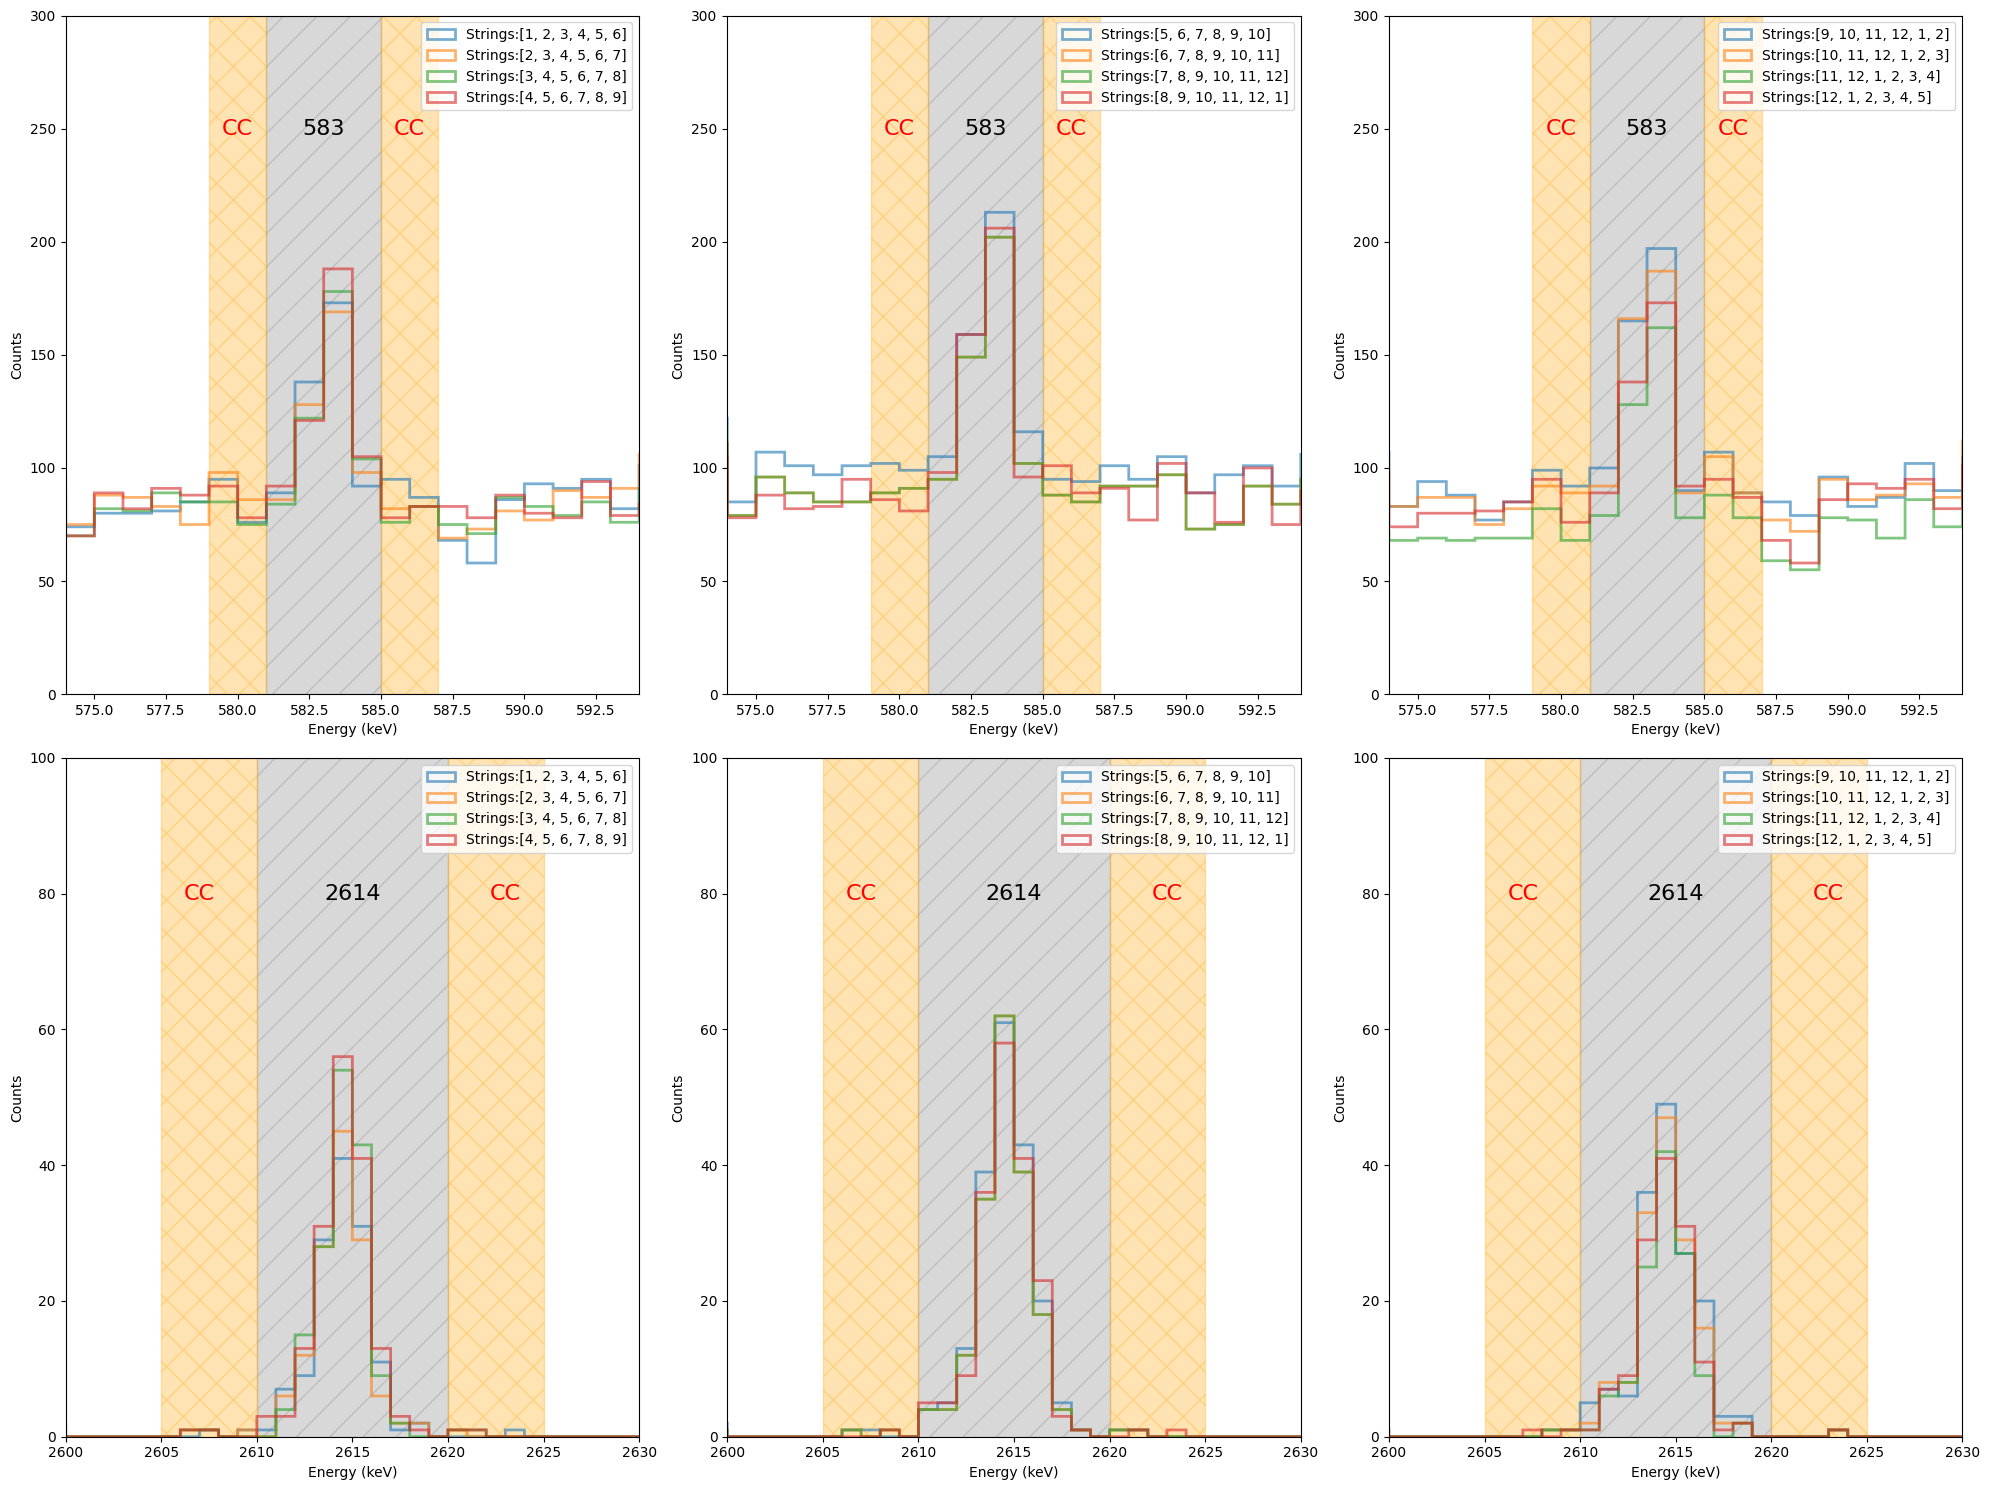

In [11]:
fig, ax = plt.subplots(2, 3, figsize = (20, 15))

ctr = -1
col = 0

counts_dict = {}

for start_string in range(1,13,1):
    stop_string = start_string + 6
    strings = np.arange(start_string, stop_string, 1)
    
    # if the string number is greater than 12
    condition = lambda x: x > 12

    # Transform elements based on the condition
    transformed_strings = [element % 12 if condition(element) else element for element in strings]
    
    data_QC_str = data_QC[(data_QC.string.isin(transformed_strings))]
    
    # Apply the additional condition (entries less than 3000)
    data_QC_str_filtered = data_QC_str[data_QC_str['energy'] < 3000]
    bins = [x for x in np.arange(0,3000)]
    
    if ctr >= 3:
        hatching(col)
        
        # Change the counters
        col = col + 1
        ctr = -1
        
    ax[0,col].hist(data_QC_str_filtered["energy"], bins=bins, histtype='step', alpha = 0.6, linewidth=2, label = f"Strings:{transformed_strings}")
    ax[0,col].legend()
    ax[0,col].set_xlim(574,594)
    ax[0,col].set_ylim(0,300)
    ax[0,col].set_ylabel("Counts")
    ax[0,col].set_xlabel("Energy (keV)")
    ss_583 = count_integrator(data_QC_str_filtered["energy"], bins, 581,585)
    bkg_583 = count_integrator(data_QC_str_filtered["energy"], bins, 579,581) + count_integrator(data_QC_str_filtered["energy"], bins, 585,587)

    ax[1,col].hist(data_QC_str_filtered["energy"], bins=bins, histtype='step', alpha = 0.6, linewidth=2, label = f"Strings:{transformed_strings}")
    ax[1,col].legend()
    ax[1,col].set_xlim(2600,2630)
    ax[1,col].set_ylim(0,100)
    ax[1,col].set_ylabel("Counts")
    ax[1,col].set_xlabel("Energy (keV)")
    ss_2614 = count_integrator(data_QC_str_filtered["energy"], bins, 2610,2620)
    bkg_2614 = count_integrator(data_QC_str_filtered["energy"], bins, 2605,2610) + count_integrator(data_QC_str_filtered["energy"], bins, 2620,2625)

    counts_dict[f"{transformed_strings}"] = {"ss_583":ss_583, "ss_err_583":np.sqrt(ss_583), "bkg_583":bkg_583, "bkg_err_583":np.sqrt(bkg_583),\
                                             "ss_2614":ss_2614, "ss_err_2614":np.sqrt(ss_2614), "bkg_2614":bkg_2614, "bkg_err_2614":np.sqrt(bkg_2614)}
    ctr = ctr + 1

hatching(col)

plt.tight_layout()
plt.show()

In [12]:
counts_df = pd.DataFrame.from_dict(counts_dict, orient='index')

In [13]:
counts_df

,ss_583,ss_err_583,bkg_583,bkg_err_583,ss_2614,ss_err_2614,bkg_2614,bkg_err_2614
"[1, 2, 3, 4, 5, 6]",492,22.181073,353,18.788294,132,11.489125,3,1.732051
"[2, 3, 4, 5, 6, 7]",481,21.931712,349,18.681542,130,11.401754,4,2.000000
"[3, 4, 5, 6, 7, 8]",488,22.090722,319,17.860571,155,12.449900,4,2.000000
"[4, 5, 6, 7, 8, 9]",506,22.494444,331,18.193405,164,12.806248,4,2.000000
"[5, 6, 7, 8, 9, 10]",593,24.351591,390,19.748418,191,13.820275,4,2.000000
"[6, 7, 8, 9, 10, 11]",548,23.409400,353,18.788294,179,13.379088,4,2.000000
"[7, 8, 9, 10, 11, 12]",548,23.409400,353,18.788294,179,13.379088,4,2.000000
"[8, 9, 10, 11, 12, 1]",559,23.643181,357,18.894444,181,13.453624,3,1.732051
"[9, 10, 11, 12, 1, 2]",552,23.494680,387,19.672316,156,12.489996,3,1.732051
"[10, 11, 12, 1, 2, 3]",534,23.108440,375,19.364917,147,12.124356,3,1.732051


In [14]:
ratios_df = pd.DataFrame({
    'N_583': counts_df['ss_583'] - counts_df['bkg_583'],\
    'N_err_583': round(np.sqrt(counts_df['ss_err_583']**2 + counts_df['bkg_err_583']**2), 0),\
    'N_2614': counts_df['ss_2614'] - counts_df['bkg_2614'],\
    'N_err_2614': round(np.sqrt(counts_df['ss_err_2614']**2 + counts_df['bkg_err_2614']**2), 0)})

In [16]:
ratios_df['R_583_2614'] = ratios_df['N_583']/ratios_df['N_2614']

In [17]:
ratios_df['R_err'] = ratios_df['R_583_2614'] * np.sqrt((ratios_df['N_err_583']/ratios_df['N_583'])**2 + (ratios_df['N_err_2614']/ratios_df['N_2614'])**2)

In [18]:
ratios_df

,N_583,N_err_583,N_2614,N_err_2614,R_583_2614,R_err
"[1, 2, 3, 4, 5, 6]",139,29.0,129,12.0,1.077519,0.246140
"[2, 3, 4, 5, 6, 7]",132,29.0,126,12.0,1.047619,0.250854
"[3, 4, 5, 6, 7, 8]",169,28.0,151,13.0,1.119205,0.208971
"[4, 5, 6, 7, 8, 9]",175,29.0,160,13.0,1.093750,0.201864
"[5, 6, 7, 8, 9, 10]",203,31.0,187,14.0,1.085561,0.184626
"[6, 7, 8, 9, 10, 11]",195,30.0,175,14.0,1.114286,0.193221
"[7, 8, 9, 10, 11, 12]",195,30.0,175,14.0,1.114286,0.193221
"[8, 9, 10, 11, 12, 1]",202,30.0,178,14.0,1.134831,0.190715
"[9, 10, 11, 12, 1, 2]",165,31.0,153,13.0,1.078431,0.222371
"[10, 11, 12, 1, 2, 3]",159,30.0,144,12.0,1.104167,0.227748
